# Geospatial Yield Analysis of Sunflower Harvest

## Ecaterina Guritanu

### I load the necessary packages. I will use geopandas library to handle geospatial data

In [133]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

### The dataset is in GPKG format so I use geopandas.read_file() to load it

In [135]:
df = gpd.read_file('resa_girasole_2022.gpkg')
df

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry
0,"5 set 2022, 10:08:09","11,9758245","44,8474908",1870.0,4.80,140.000,NaN,POINT (1.33e+06 5.6e+06)
1,"5 set 2022, 10:08:24","11,9758157","44,8476751",1270.0,4.83,140.875,NaN,POINT (1.33e+06 5.6e+06)
2,"5 set 2022, 10:08:40","11,9758154","44,8478795",1420.0,4.78,139.417,NaN,POINT (1.33e+06 5.6e+06)
3,"5 set 2022, 10:08:55","11,9758209","44,8480593",2010.0,4.85,141.458,33.1,POINT (1.33e+06 5.6e+06)
4,"5 set 2022, 10:09:10","11,9758201","44,8482443",1320.0,4.80,140.000,33.1,POINT (1.33e+06 5.6e+06)
...,...,...,...,...,...,...,...,...
1957,"3 set 2022, 20:13:03","11,9757431","44,8480422",2260.0,4.77,139.125,30.8,POINT (1.33e+06 5.6e+06)
1958,"3 set 2022, 20:13:19","11,9757395","44,8482399",2460.0,4.78,139.417,24.6,POINT (1.33e+06 5.6e+06)
1959,"3 set 2022, 20:13:34","11,9757408","44,8484282",2330.0,4.78,139.417,24.6,POINT (1.33e+06 5.6e+06)
1960,"3 set 2022, 20:13:49","11,9757414","44,848618",1950.0,4.99,145.542,24.6,POINT (1.33e+06 5.6e+06)


In [136]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1962 entries, 0 to 1961
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Data/Ora    1962 non-null   object  
 1   Longitudin  1962 non-null   object  
 2   Latitudine  1962 non-null   object  
 3   RESAKG      1962 non-null   float64 
 4   VELOCITA    1962 non-null   float64 
 5   AREA        1962 non-null   float64 
 6   UMIDITA     1925 non-null   float64 
 7   geometry    1962 non-null   geometry
dtypes: float64(4), geometry(1), object(3)
memory usage: 122.8+ KB


# 1. Data Cleaning

### I convert the decimal separator from comma to dot as I'm working with geopandas

In [137]:
df["Longitudin"] = df["Longitudin"].str.replace(",", ".").astype(float)
df["Latitudine"] = df["Latitudine"].str.replace(",", ".").astype(float)

### I convert 'Data/Ora' to datetime format and replace italian month names with english ones

In [138]:
df["Data/Ora"] = df["Data/Ora"].str.replace("set", "Sep", regex=True)
df["Data/Ora"] = df["Data/Ora"].str.replace("ago", "Aug", regex=True)

df["Data/Ora"] = pd.to_datetime(df["Data/Ora"], format="%d %b %Y, %H:%M:%S", errors="coerce")

### I check for missing values

In [139]:
df.isnull().sum()

Data/Ora       0
Longitudin     0
Latitudine     0
RESAKG         0
VELOCITA       0
AREA           0
UMIDITA       37
geometry       0
dtype: int64

### I remove missing values from 'UMIDITA', since they are only 37 out of 1962

In [140]:
df = df.dropna()

### I reset the index

In [141]:
df = df.reset_index(drop=True)

### I check for duplicates, however there are none

In [142]:
df.duplicated().sum()

0

### I check again the data 

In [143]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Data/Ora    1925 non-null   datetime64[ns]
 1   Longitudin  1925 non-null   float64       
 2   Latitudine  1925 non-null   float64       
 3   RESAKG      1925 non-null   float64       
 4   VELOCITA    1925 non-null   float64       
 5   AREA        1925 non-null   float64       
 6   UMIDITA     1925 non-null   float64       
 7   geometry    1925 non-null   geometry      
dtypes: datetime64[ns](1), float64(6), geometry(1)
memory usage: 120.4 KB


# 2. Exploratory Data Analysis

In [144]:
df.describe()

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA
count,1925,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000
mean,2022-09-03 15:58:58.582338048,11.971300,44.848600,2254.374026,4.900068,142.918646,27.022805
min,2022-08-31 16:26:24,11.964918,44.847392,50.000000,0.780000,22.750000,18.600000
25%,2022-09-03 13:30:03,11.967683,44.847884,1790.000000,4.570000,133.292000,22.200000
50%,2022-09-03 16:23:01,11.970669,44.848461,2300.000000,4.890000,142.625000,25.800000
75%,2022-09-03 19:13:11,11.974312,44.849198,2730.000000,5.170000,150.792000,30.200000
max,2022-09-05 12:23:14,11.983093,44.850986,4880.000000,10.910000,318.208000,50.100000
std,NaN,0.004342,0.000842,701.198325,0.617205,18.001814,6.154021


### I plot histograms to check distributions of key variables

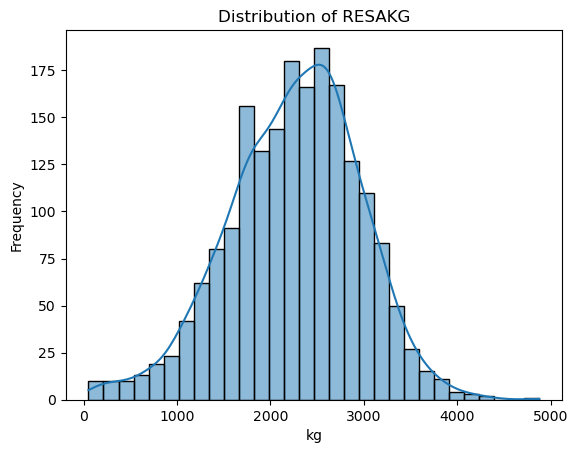

In [145]:
sns.histplot(df["RESAKG"], bins=30, kde=True)
plt.title("Distribution of RESAKG")
plt.xlabel("kg")
plt.ylabel("Frequency")
plt.show()

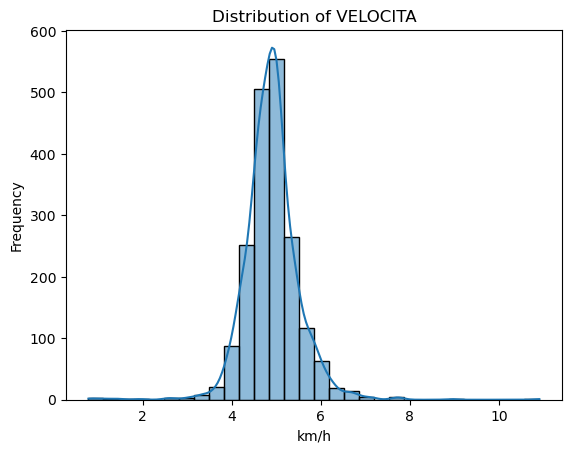

In [146]:
sns.histplot(df["VELOCITA"], bins=30, kde=True)
plt.title("Distribution of VELOCITA")
plt.xlabel("km/h")
plt.ylabel("Frequency")
plt.show()

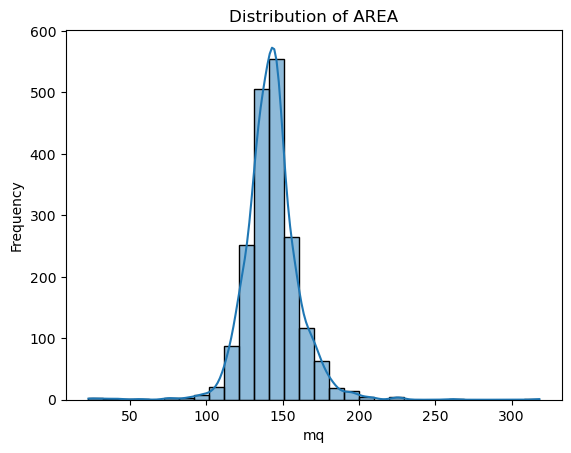

In [147]:
sns.histplot(df["AREA"], bins=30, kde=True)
plt.title("Distribution of AREA")
plt.xlabel("mq")
plt.ylabel("Frequency")
plt.show()

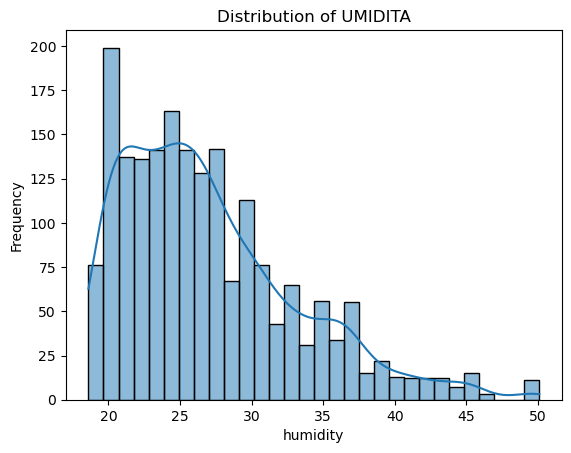

In [148]:
sns.histplot(df["UMIDITA"], bins=30, kde=True)
plt.title("Distribution of UMIDITA")
plt.xlabel("humidity")
plt.ylabel("Frequency")
plt.show()

### The distributions seem ok: 
### - 'UMIDITA' is a bit right skewed but not enough to apply transormations 
### - 'VELOCITA' and 'AREA' might have outliers so I check with a boxplot

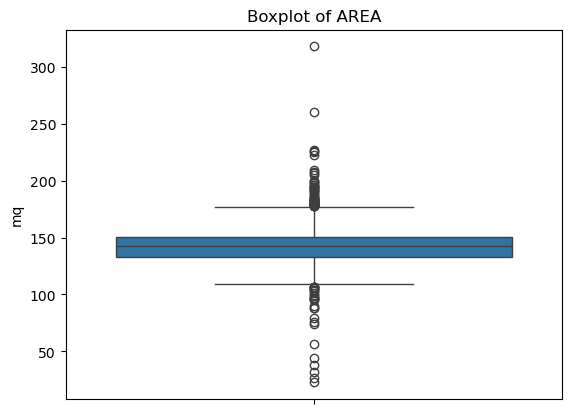

In [149]:
sns.boxplot(y=df["AREA"])
plt.title("Boxplot of AREA")
plt.ylabel("mq")
plt.show()

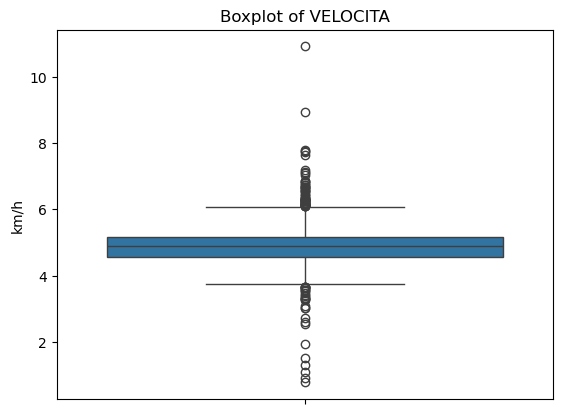

In [150]:
sns.boxplot(y=df["VELOCITA"])
plt.title("Boxplot of VELOCITA")
plt.ylabel("km/h")
plt.show()

### Outliers in 'AREA' and 'VELOCITA' are reasonable, so I keep the data unchanged

# 3. Spatial Interpolation
### I want to create a yield map interpolating 'RESAKG' over the field. 
### The dataset uses latitude and longitude, but I want to convert it to UTM zone 32N, where Jolanda Di Savoia is. Now the coordinates are in meters instead of degrees

In [151]:
df.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [152]:
df = df.to_crs(epsg=32632) 

In [153]:
df.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Now I have to create a grid of points for interpolation. I get the min and max x coordinates, min and max y coordinates, and create 100 point spaced evenly between min and max, that is, a 100x100 grid.

In [154]:
grid_x, grid_y = np.mgrid[
    df.geometry.x.min():df.geometry.x.max():100j,
    df.geometry.y.min():df.geometry.y.max():100j]

### I plot the grid 

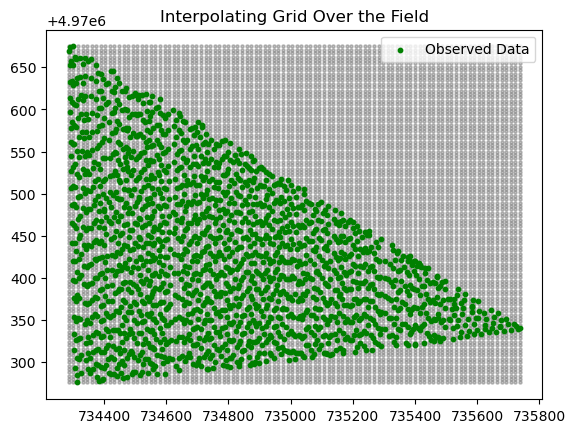

In [155]:
plt.scatter(grid_x, grid_y, color='gray', alpha=0.5, s=5) 
plt.scatter(df.geometry.x, df.geometry.y, color='green', s=10, label="Observed Data")
plt.title("Interpolating Grid Over the Field")
plt.legend()
plt.show()

### In order to interpolare 'RESAKG' values I will use the Inverse Distance Weighting. It estimates unknown values based on near known values and closer points have higher influence than farther points.

### I extract x and y coordinates and yield values

In [156]:
x = df.geometry.x.values
y = df.geometry.y.values
z = df["RESAKG"].values

### I flatten the grid arrays to apply IDW

In [157]:
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

### I build a KDTree for fast spatial queries

In [158]:
tree = cKDTree(np.vstack((x, y)).T)

### IDW function for interpolation

In [159]:
def idw_interpolation(xyz, grid_points):
    xi, yi, zi = xyz
    distances, indices = tree.query(grid_points, k=5)       # this finds 5 nearest neighbors
    weights = 1.0 / (distances ** 2)           # the weights are inversely proportional to distance
    weights /= weights.sum(axis=1, keepdims=True)        # this normalizes weights
    interpolated_values = np.sum(weights * zi[indices], axis=1)
    return interpolated_values

In [160]:
grid_resa = idw_interpolation((x, y, z), grid_points)

### I reshape the interpolated values to match the grid

In [161]:
grid_resa = grid_resa.reshape(grid_x.shape)

### Visualize the interpolated yield map

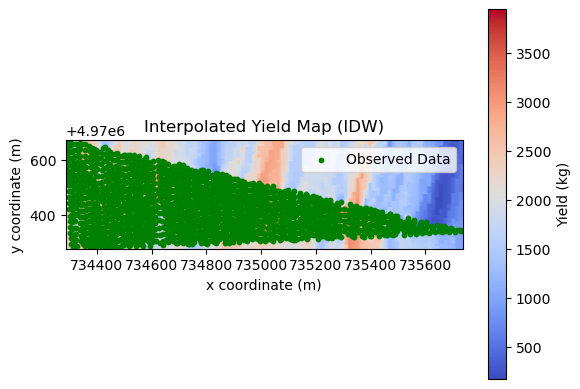

In [162]:
plt.imshow(grid_resa.T, extent=(
    df.geometry.x.min(), df.geometry.x.max(),
    df.geometry.y.min(), df.geometry.y.max()
), origin="lower", cmap="coolwarm")

plt.colorbar(label="Yield (kg)")
plt.scatter(df.geometry.x, df.geometry.y, c="green", s=10, label="Observed Data") 
plt.title("Interpolated Yield Map (IDW)")
plt.xlabel("x coordinate (m)")
plt.ylabel("y coordinate (m)")
plt.legend()
plt.show()

### I see alternations of high yield areas and low yield areas. High yield areas are areas where the crop produced more yield per unit area. Might be areas with more fertility, better irrigation, or a correlation with the speed of the harvester.

### These observations suggests looking at the correlation between the yield and the harvester speed or humidity 

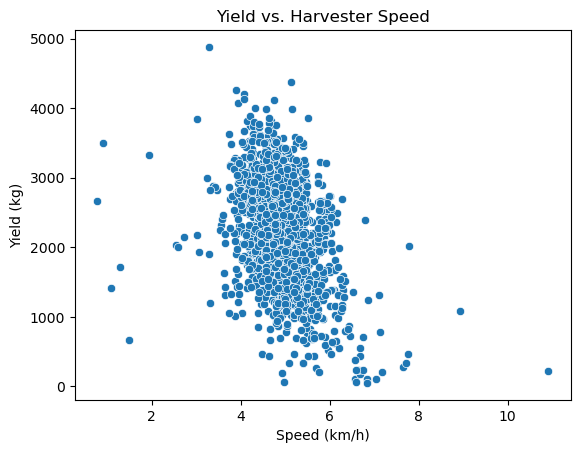

In [163]:
sns.scatterplot(x=df["VELOCITA"], y=df["RESAKG"])
plt.title("Yield vs. Harvester Speed")
plt.xlabel("Speed (km/h)")
plt.ylabel("Yield (kg)")
plt.show()

### The yield is higher at moderate speed, around 4-6 km/h. The yield is lower at higher speedd, over 7 km/h)

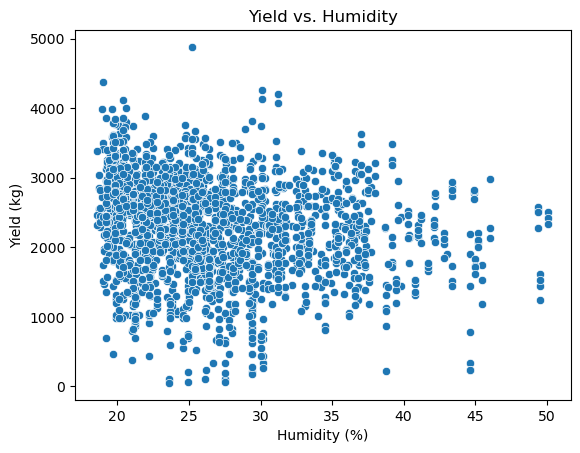

In [164]:
sns.scatterplot(x=df["UMIDITA"], y=df["RESAKG"])
plt.title("Yield vs. Humidity")
plt.xlabel("Humidity (%)")
plt.ylabel("Yield (kg)")
plt.show()

### Humidity doesn't seem to have a strong correlation with yield. 

# 4. Correlate yield with a vegetational vigor index 

### I will compute a simple vigor index based on the data available. An indicator of vegetational vigor is the yield per harvested area, including the level of humidity that affects vigor. 

$$
Index = \frac{RESAKG}{AREA} \times \frac{UMIDITA}{100}
$$

In [165]:
df["Veg_Index"] = (df["RESAKG"] / df["AREA"]) * (df["UMIDITA"] / 100)

In [166]:
df[["RESAKG", "AREA", "UMIDITA", "Veg_Index"]].head()

,RESAKG,AREA,UMIDITA,Veg_Index
0,2010.0,141.458,33.1,4.703233
1,1320.0,140.000,33.1,3.120857
2,1440.0,142.917,33.1,3.335083
3,1160.0,141.750,33.1,2.708713
4,1160.0,140.583,33.1,2.731198


### Now I correlate the vegetational vigor index with yield, 

In [167]:
corr = df["Veg_Index"].corr(df["RESAKG"])
corr

0.6485675849661693

### The correlation is high, so the index is a good predictor of yield, there are still other factors that also affect yield.

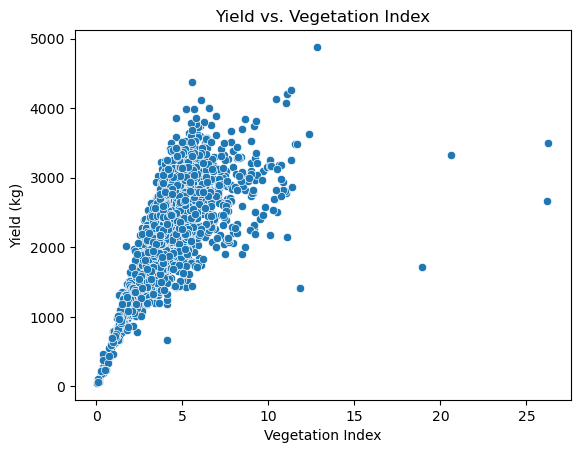

In [168]:
sns.scatterplot(x=df["Veg_Index"], y=df["RESAKG"])
plt.title("Yield vs. Vegetation Index")
plt.xlabel("Vegetation Index")
plt.ylabel("Yield (kg)")
plt.show()

### There is a clear trend: as the vegetation index increases, yield also increases. This means that areas with higher vegetation vigor tend to produce higher yield.